# Removing Duplicate Objects

This recipe demonstrates a simple workflow for finding and removing duplicate objects in your FiftyOne datasets using [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index).

Specificially, it covers:

- Using the [compute_max_ious()](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.iou.html#fiftyone.utils.iou.compute_max_ious) utility to compute overlap between spatial objects
- Using the [App's tagging UI](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging) to review and delete duplicate labels
- Using FiftyOne's [CVAT integration](https://voxel51.com/docs/fiftyone/integrations/cvat.html) to edit duplicate labels
- Using the [find_duplicates()](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.iou.html#fiftyone.utils.iou.find_duplicates) utility to automatically detect duplicate objects

Also, check out [our blog post](https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1) for more information about using IoU to evaluate your object detection models.

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

## Load a dataset

In this recipe, we'll work with the validation split of the [COCO dataset](https://cocodataset.org/#home), which is conveniently available for download via the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#coco-2017).

The snippet below downloads and loads a subset of the validation split into FiftyOne:

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("coco-2017", split="validation", max_samples=1000)

Found annotations at '/Users/Brian/fiftyone/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 1000/1000 [4.9s elapsed, 0s remaining, 216.7 samples/s]      
Dataset 'coco-2017-validation-1000' created


Let's print the dataset to see what we downloaded:

In [2]:
print(dataset)

Name:        coco-2017-validation-1000
Media type:  image
Num samples: 1000
Persistent:  False
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


## Finding duplicate objects

Now let's use the [compute_max_ious()](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.iou.html#fiftyone.utils.iou.compute_max_ious) utility to compute the maximum IoU between each object in the `ground_truth` field with another object of the same class (`classwise=True`) within the same image.

The max IOU will be stored in a `max_iou` attribute of each object, and the idea here is that duplicate objects will necessarily have high [IoU](https://en.wikipedia.org/wiki/Jaccard_index) with another object.

In [3]:
import fiftyone.utils.iou as foui

foui.compute_max_ious(dataset, "ground_truth", iou_attr="max_iou", classwise=True)
print("Max IoU range: (%f, %f)" % dataset.bounds("ground_truth.detections.max_iou"))

 100% |███████████████| 1000/1000 [3.2s elapsed, 0s remaining, 348.2 samples/s]      
Max IoU range: (0.000000, 0.951640)


Note that [compute_max_ious()](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.iou.html#fiftyone.utils.iou.compute_max_ious) provides an optional `other_field` parameter if you would like to compute IoUs between objects in different fields instead.

In any case, let's [create a view](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering-sample-contents) that contains only labels with a max IoU > 0.75:

In [4]:
from fiftyone import ViewField as F

# Retrieve detections that overlap above a chosen threshold
dups_view = dataset.filter_labels("ground_truth", F("max_iou") > 0.75)
print(dups_view)

Dataset:     coco-2017-validation-1000
Media type:  image
Num samples: 7
Tags:        ['validation']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. FilterLabels(field='ground_truth', filter={'$gt': ['$$this.max_iou', 0.75]}, only_matches=True, trajectories=False)


and load it in the App:


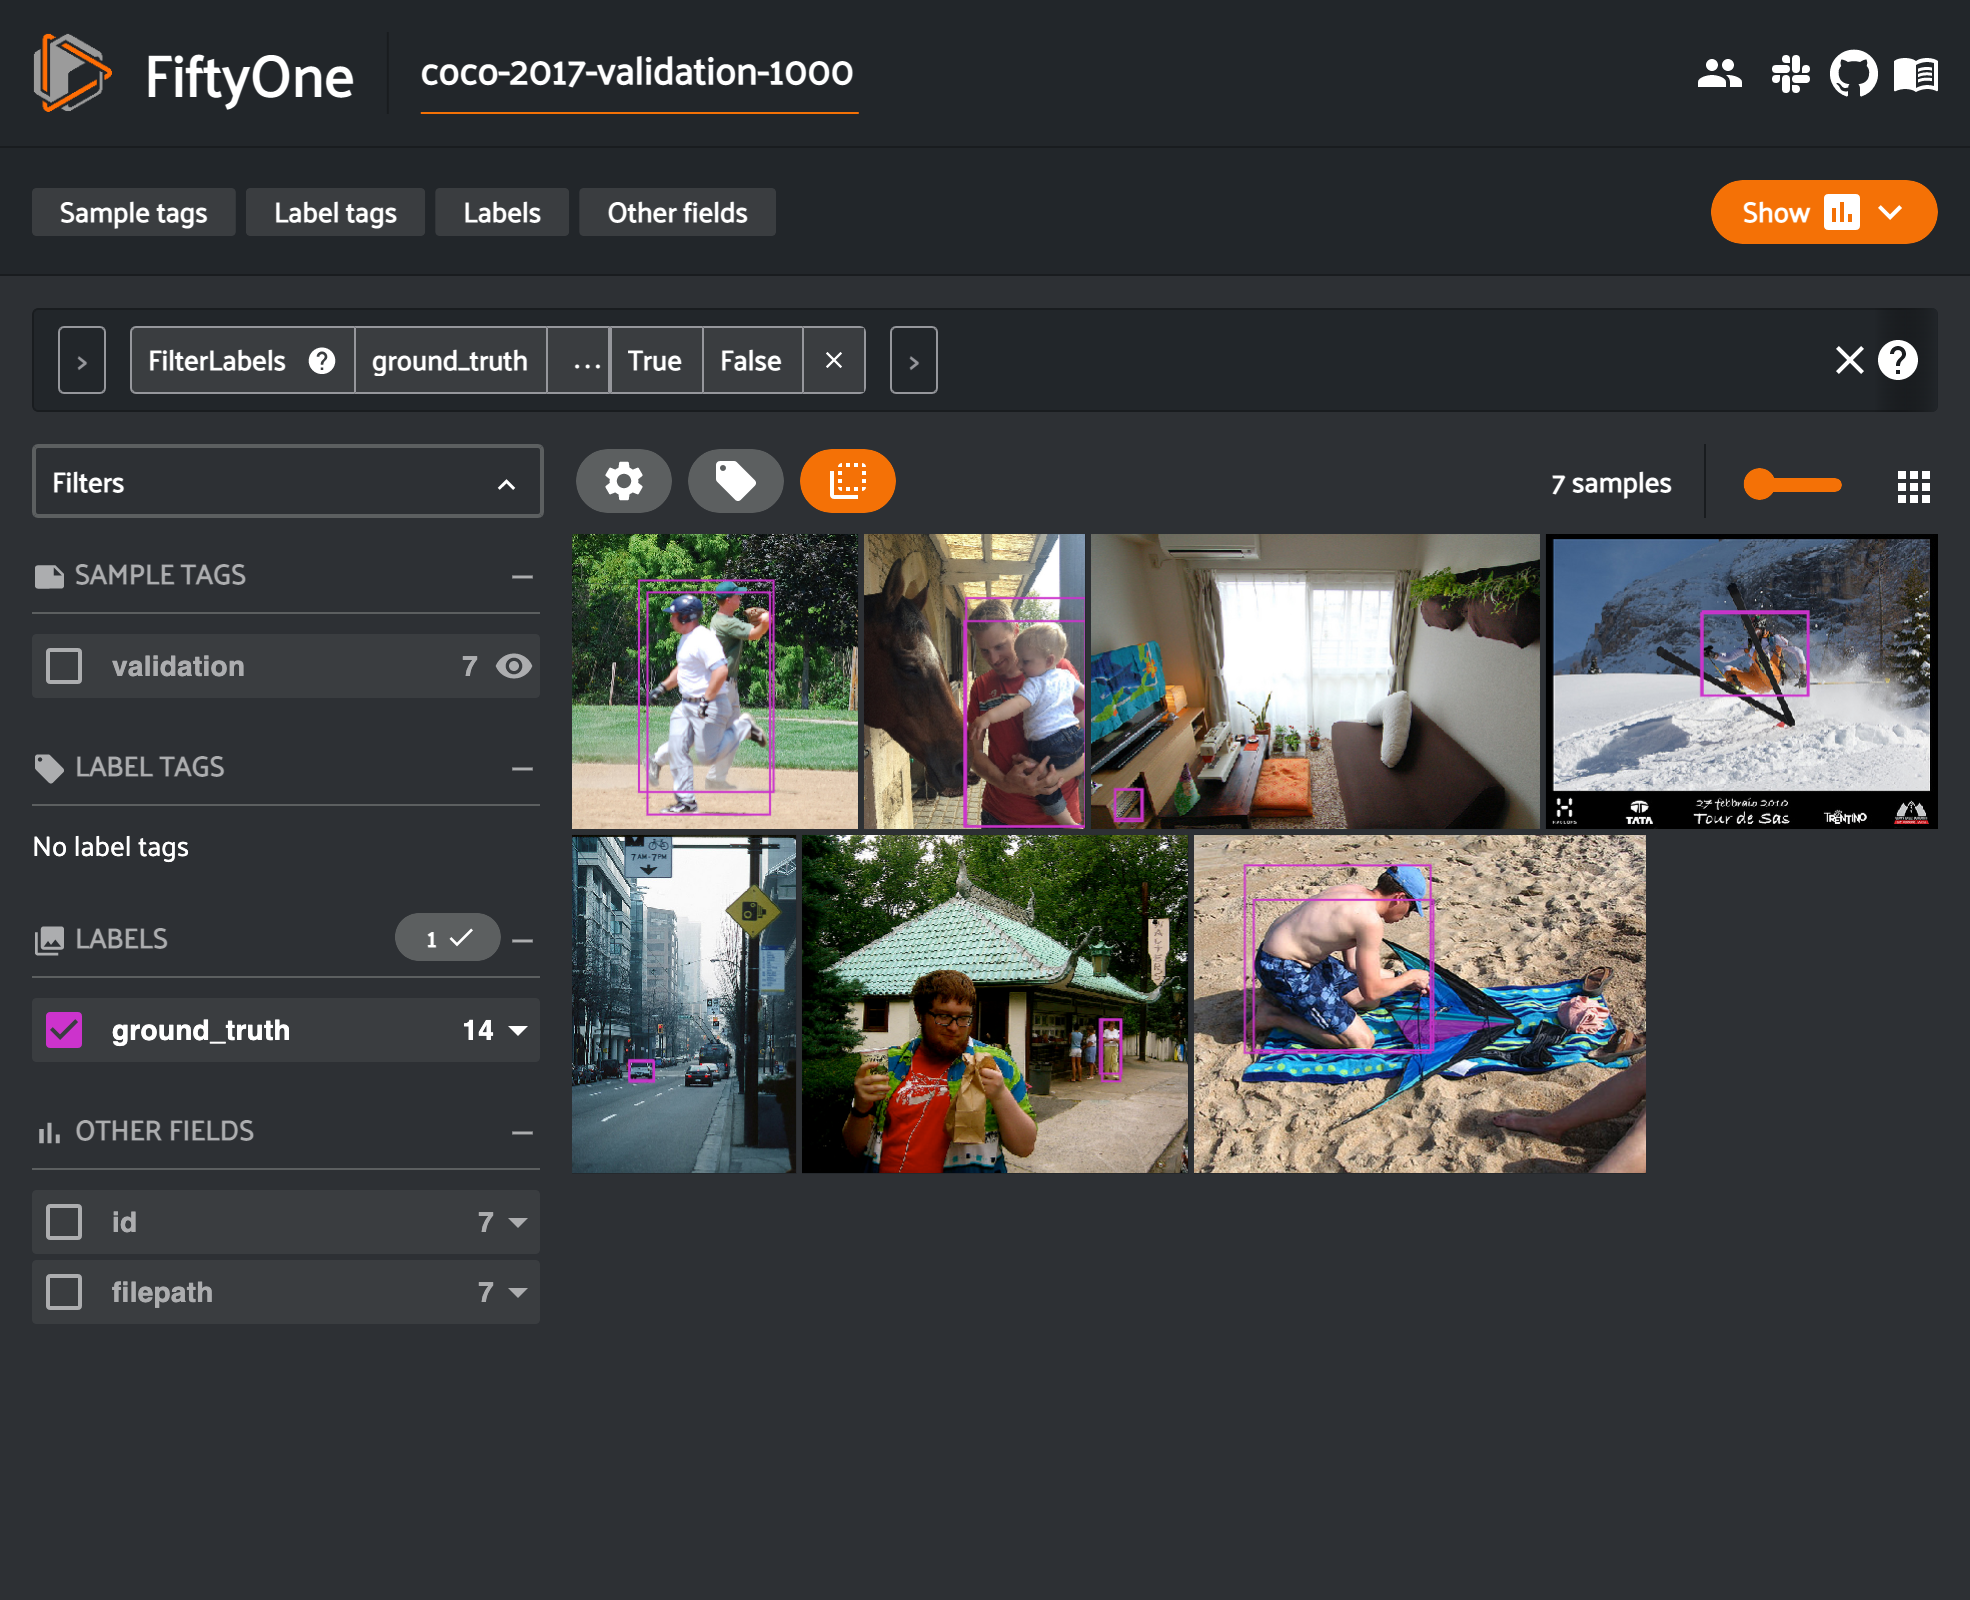

In [8]:
session = fo.launch_app(view=dups_view)

## Removing duplicates in the App

One simple approach to removing the duplicate labels is to review them in the App and [assign label tags](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging) to the labels that we deem to be duplicates:


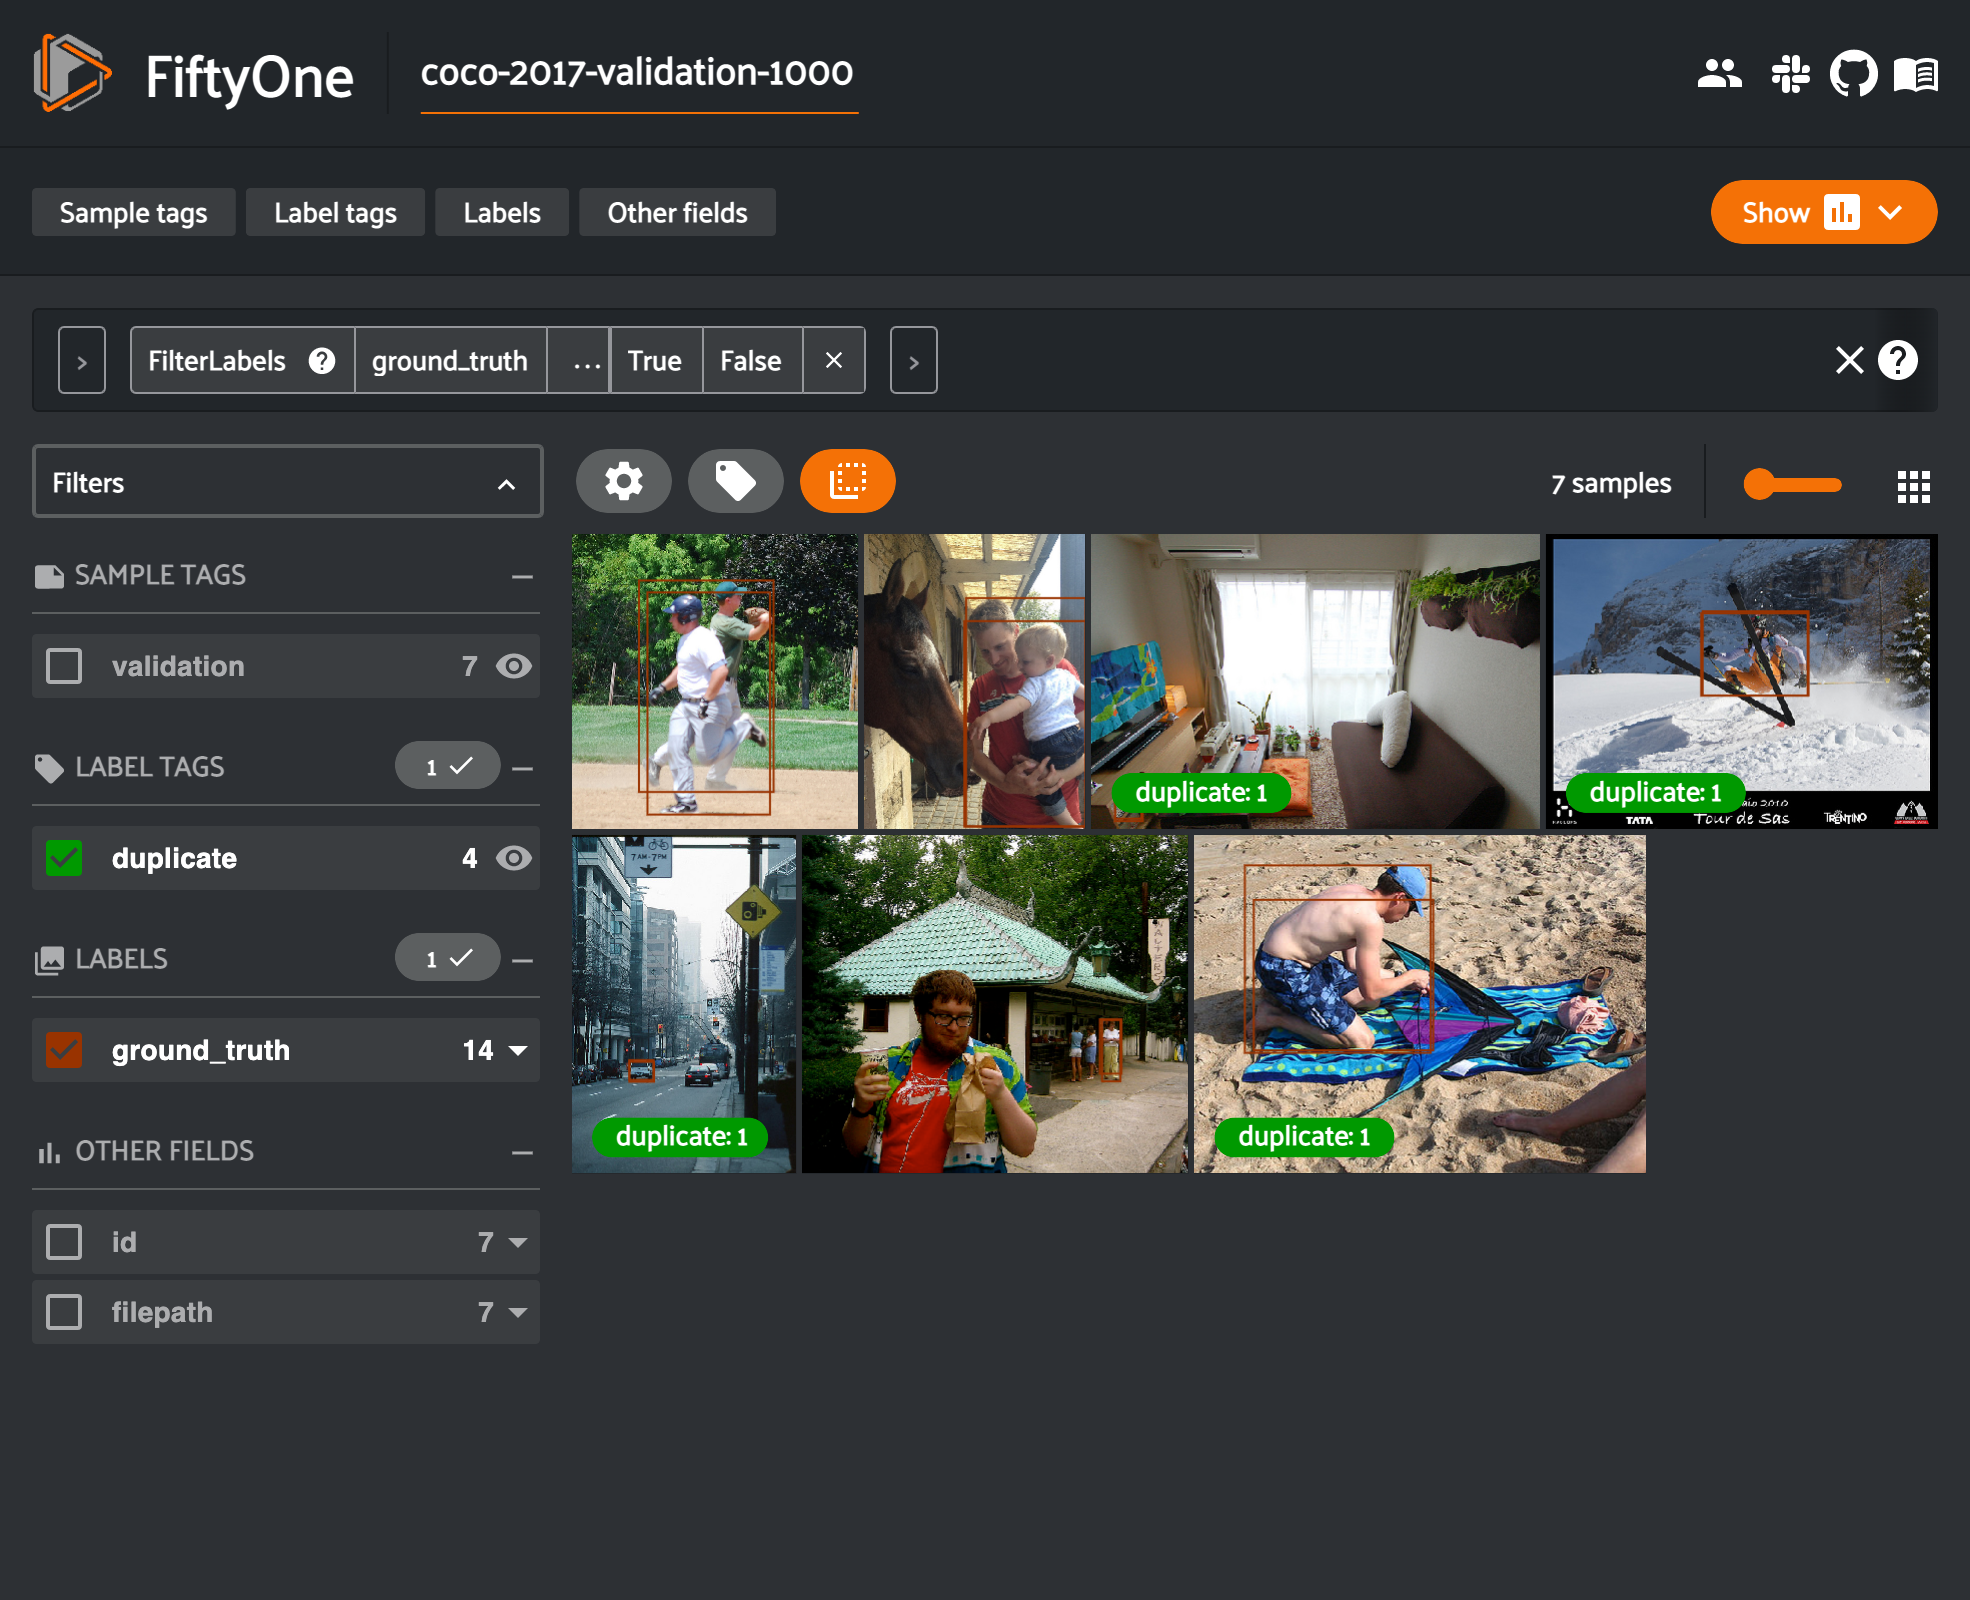

In [9]:
session.show()

Then we can simply delete the labels with the duplicate tag that we populated:

In [16]:
dataset.delete_labels(tags="duplicate")

# Verify that tagged labels were deleted
print(dataset.count_label_tags())

{}


## Removing duplicates in CVAT

Another approach to resolve the duplicate labegls is to use FiftyOne's [CVAT integration](https://voxel51.com/docs/fiftyone/integrations/cvat.html) to upload the duplicate labels to CVAT for review, editing, and/or deletion:

In [12]:
anno_key = "remove_dups"
dups_view.annotate(anno_key, label_field="ground_truth", launch_editor=True)

Uploading samples to CVAT...
Upload complete
Launching editor at 'http://localhost:8080/tasks/286/jobs/292'...


![cvat-remove-dups](images/cvat_remove_dups.jpg)

Once we're finished editing in CVAT, we simply load the results back into FiftyOne:

In [ ]:
dataset.load_annotations(anno_key)

and refresh the App to verify that the duplicates have been properly addressed:


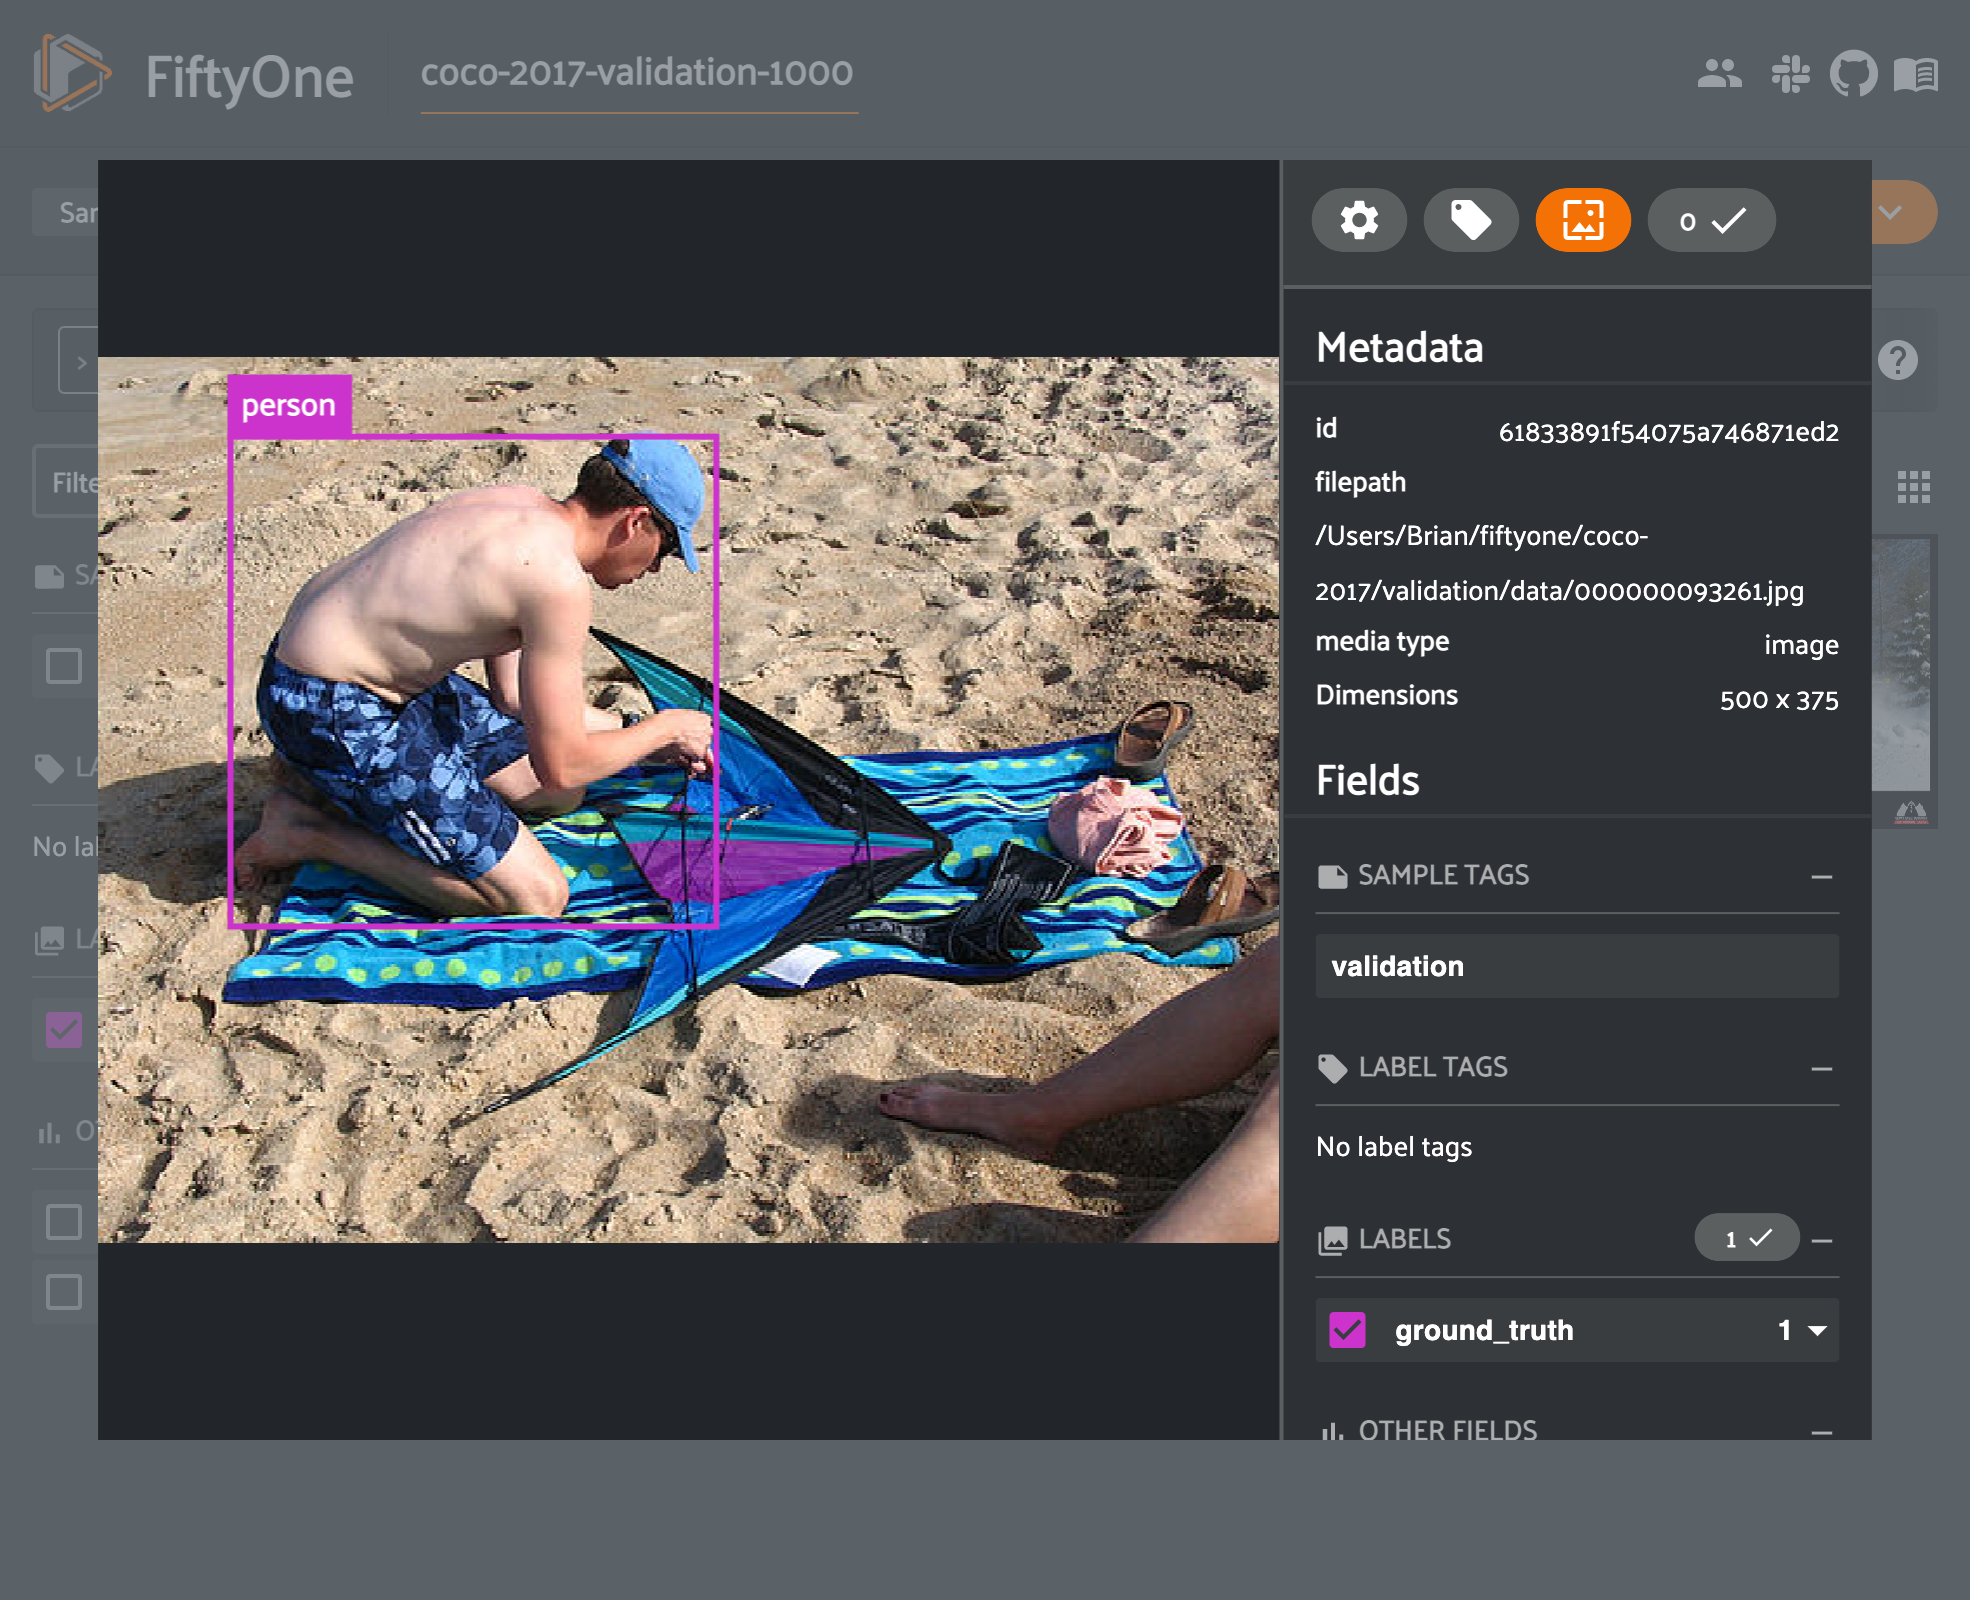

In [14]:
session.show()

## Automatically finding duplicates

A third approach is to use the [find_duplicates()](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.iou.html#fiftyone.utils.iou.find_duplicates) utility to automatically retrieve the IDs of duplicate labels:

In [6]:
dup_ids = foui.find_duplicates(
    dataset, "ground_truth", iou_thresh=0.75, classwise=True
)
print("Found %d duplicates" % len(dup_ids))

 100% |███████████████| 1000/1000 [3.5s elapsed, 0s remaining, 315.1 samples/s]      
Found 7 duplicates


Of course, when dealing with duplicate labels, there is inherent ambiguity: which one is "correct" and which one(s) are "duplicate"?

By default, [find_duplicates()](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.iou.html#fiftyone.utils.iou.find_duplicates) will simply iterate through the labels in each sample and flag any label whose IoU with a previous label exceeds the chosen threshold as a duplicate.

Alternatively, you can pass the `method="greedy"` option to instead use a greedy approach to mark the fewest number of labels as duplicate such that no non-duplicate labels have IoU greater than the specified threshold with each other.

In either case, it is recommended to visualize the duplicates in the App before taking any action. One convenient way to do this is to first tag the duplicates:

In [11]:
# Cleanup any previous tags (if necessary)
dataset.untag_labels("duplicate")

In [12]:
# Tag the automatically selected duplicates
dataset.select_labels(ids=dup_ids).tag_labels("duplicate")
print(dataset.count_label_tags())

{'duplicate': 7}


Then, use [match_labels()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.match_labels) to load the samples containing at least one duplicate label in the App and use the `duplicate` tag you added to conveniently isolate and evaluate the duplicates.

If you see any erroneous duplicates, simply remove the `duplicate` tag in the App:


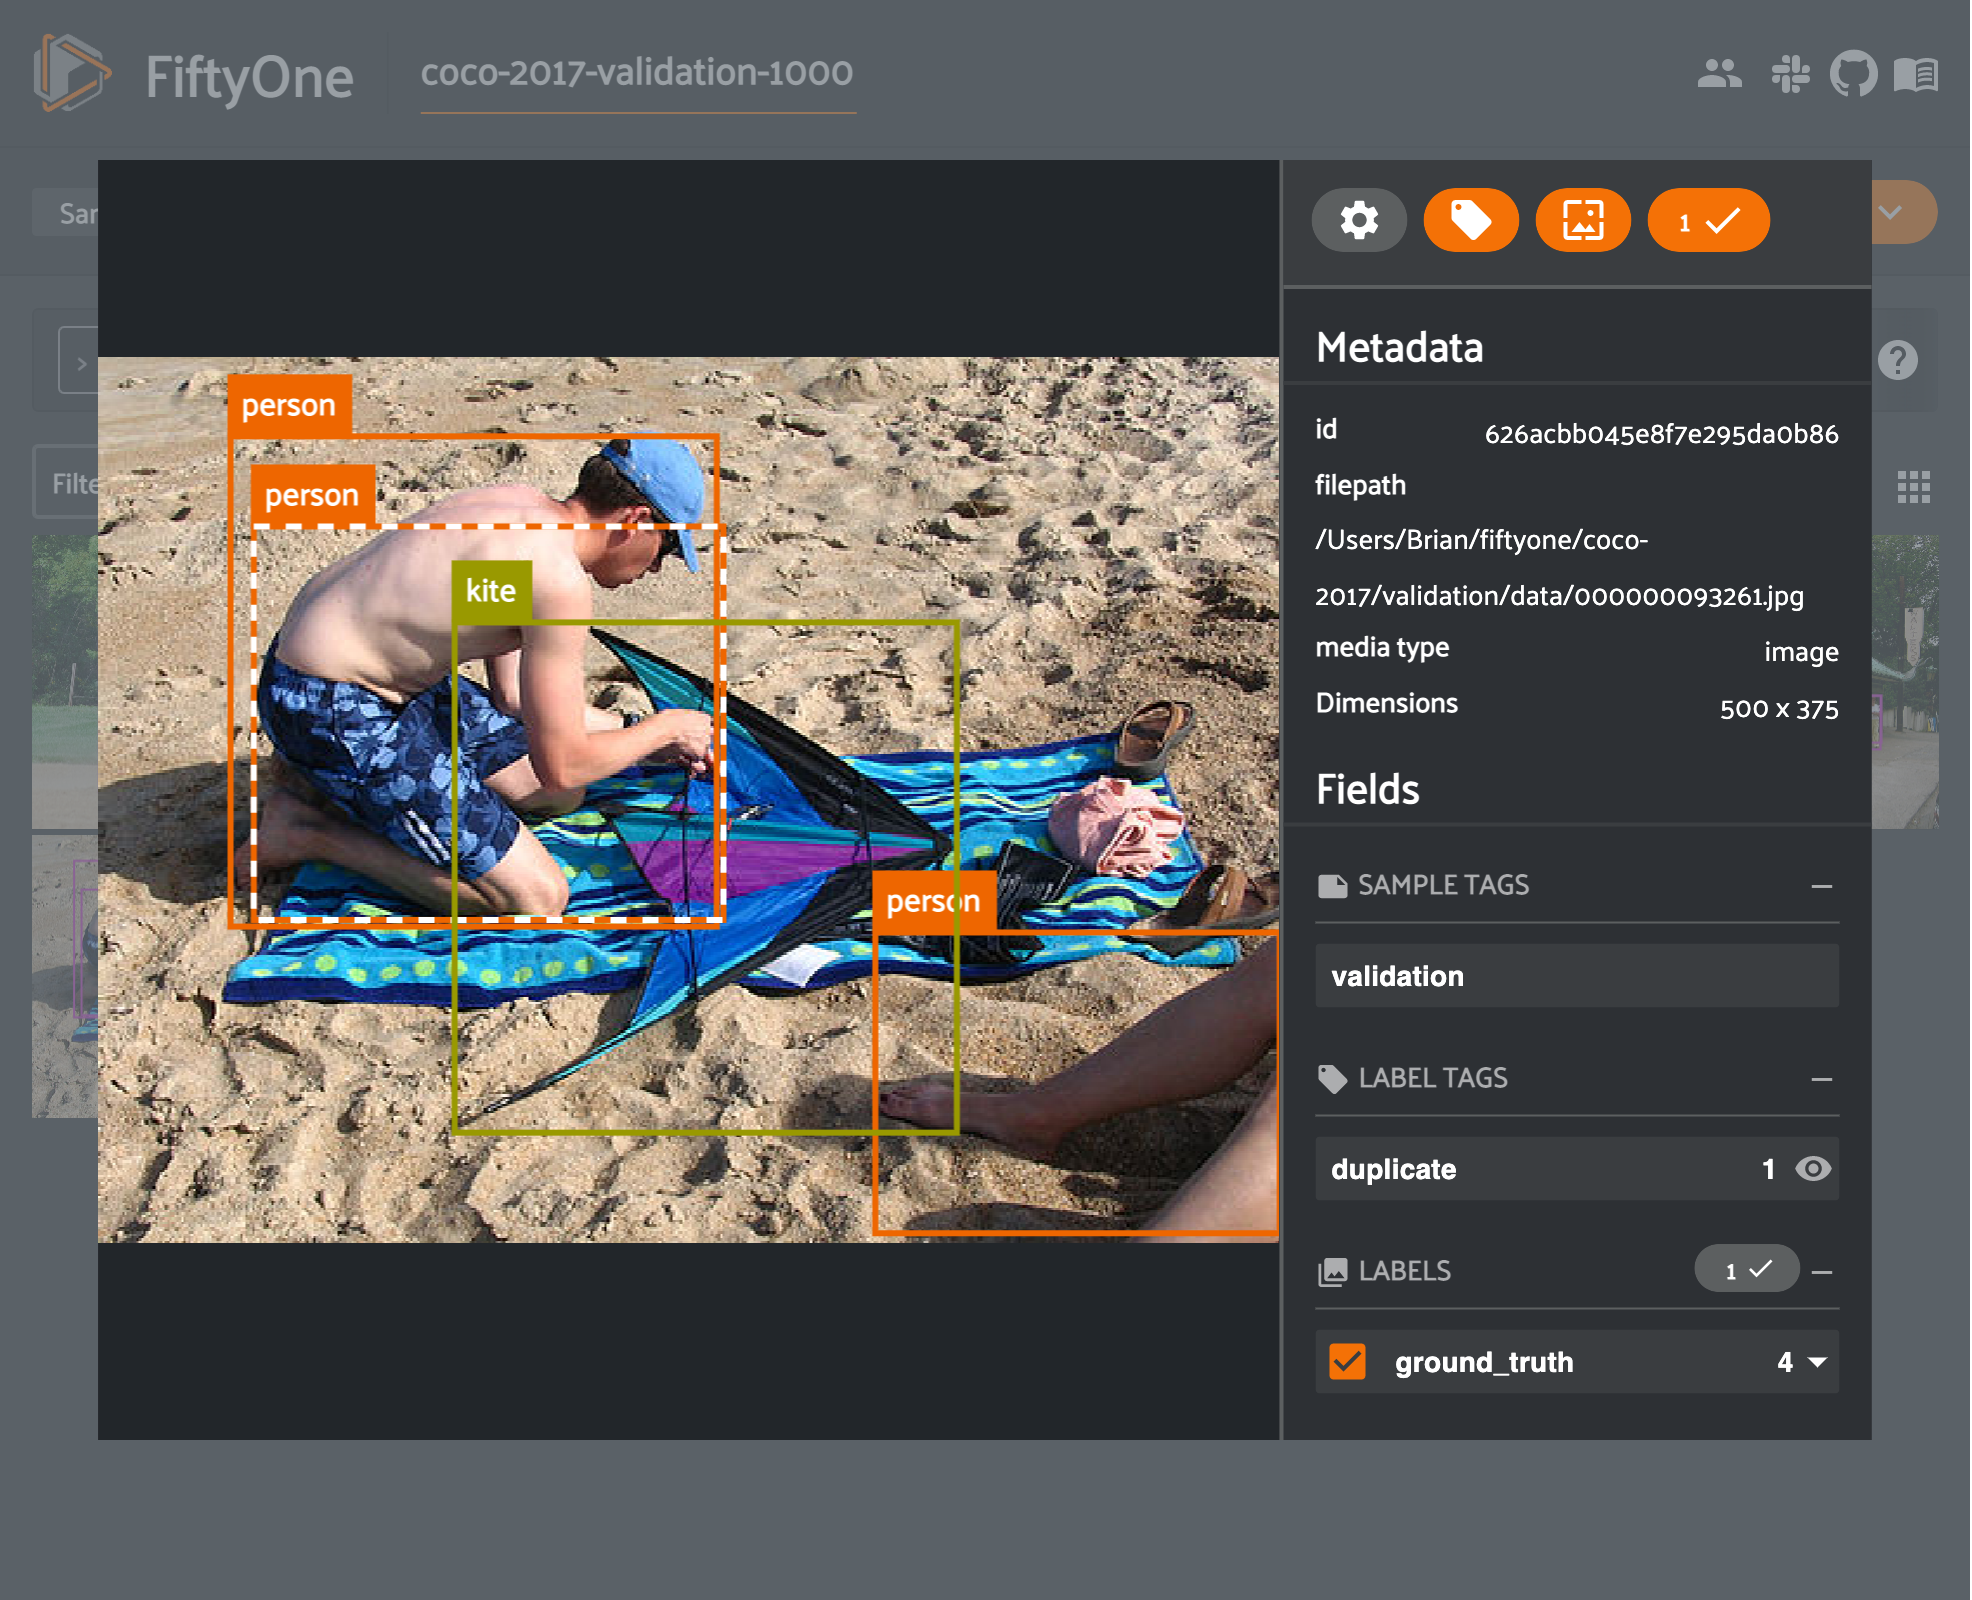

In [16]:
session.view = dataset.match_labels(ids=dup_ids)

When you're ready to act, you can then easily delete the duplicate labels as follows:

In [17]:
dataset.delete_labels(tags="duplicate")

# If you want to delete every label flagged by `find_duplicates()`
# dataset.delete_labels(ids=dup_ids)

In [18]:
session.freeze() # screenshot the active App for sharing